<a href="https://colab.research.google.com/github/james-kidd/portfolio_anlaysis/blob/main/JamesKidd_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


ETF Holdings Modeling — Public Data Case Study

This notebook demonstrates how public ETF holdings + ETF performance data can be used to train a simple model that estimates the probability that a stock appears among an ETF’s top holdings.

Focus on:

  - Clean, reproducible data ingestion
  - ETF-level and stock-level feature engineering
  - Model transparency (Logistic Regression)
  - Practical diagnostics
  - Realistic limitations and expansion points



## Setup

In [ ]:
!pip install requests yfinance --quiet

import io
import requests
import re
import time
import random

import pandas as pd
import numpy as np
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
    log_loss,
    f1_score,
)

RANDOM_STATE = 42
TOP_K = 25



## Load ETF Universe

Pulled the full iShares ETF universe from their public API and extract the metadata needed to identify and filter our sample of equity ETFs.


In [ ]:
# @title
ISHARES_SCREENER_URL = (
    "https://www.ishares.com/us/product-screener/product-screener-v3.jsn"
    "?dcrPath=/templatedata/config/product-screener-v3/data/en/us-ishares/product-screener-ketto"
)

raw = requests.get(ISHARES_SCREENER_URL).json()

cols = [c["name"] for c in raw["data"]["tableData"]["columns"]]
rows = raw["data"]["tableData"]["data"]

df_funds = pd.DataFrame(
    [
        {
            col_name: (value[0] if isinstance(value, list) else value)
            for col_name, value in zip(cols, row)
        }
        for row in rows
    ]
)


In [ ]:
# @title
prefixes = ["aladdin", "esg", "gls", "nav", "model", "investment"]

def strip_prefix(c):
    for p in prefixes:
        if c.lower().startswith(p):
            return c[len(p):]
    return c

df_funds.columns = df_funds.columns.map(strip_prefix)


To keep a consolidated security-level dataset, will asses only US market ETFs.

Apply uniform cleaning rules across all holdings:
- Keep only **equity securities**
- Require **USD currency**  
- Require **U.S. exchanges** (NYSE, NASDAQ, AMEX)  

In [ ]:

us_equity_etfs = df_funds[
    (df_funds["AssetClass"] == "Equity") &
    (df_funds["Country"] == "United States") &   # ETF domicile: US
    (df_funds["Region"] == "North America") &    # Or could be "United States"
    df_funds["localExchangeTicker"].notna()      # Must have tradable ETF ticker
]

universe = us_equity_etfs.sample(30, random_state=RANDOM_STATE).reset_index(drop=True)
universe[["localExchangeTicker", "fundName"]]


,localExchangeTicker,fundName
0,IVE,iShares S&P 500 Value ETF
1,TEND,iShares Large Cap 10% Target Buffer Dec ETF
2,BKTSX,iShares Total U.S. Stock Market Index Fund
3,BSPSX,iShares S&P 500 Index Fund
4,MAXJ,iShares Large Cap Max Buffer Jun ETF
5,QTOP,iShares Nasdaq Top 30 Stocks ETF
6,IHE,iShares U.S. Pharmaceuticals ETF
7,IYK,iShares U.S. Consumer Staples ETF
8,IYH,iShares U.S. Healthcare ETF
9,IYF,iShares U.S. Financials ETF


In [ ]:
# @title
def holdings_url(row):
    base = "https://www.ishares.com"
    page = row["productPageUrl"].rstrip("/")
    ticker = row["localExchangeTicker"]
    return (
        f"{base}{page}/1467271812596.ajax"
        f"?fileType=csv&fileName={ticker}_holdings&dataType=fund"
    )

# Stable holdings fetcher
def fetch_holdings_for_etf(row, top_k=TOP_K):
    url = holdings_url(row)
    r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    lines = r.text.splitlines()

    # Identify CSV header
    header_idx = next(i for i, ln in enumerate(lines) if ln.startswith("Ticker,"))
    df = pd.read_csv(io.StringIO("\n".join(lines[header_idx:])))
    df = df.dropna(how="all")

    # Keep only U.S.-listed equities
    df = df[
        (df["Asset Class"] == "Equity") &
        (df["Currency"] == "USD") &
        (df["Exchange"].isin(["NYSE", "NASDAQ", "AMEX"]))
    ]

    # Robust detection of weight column
    weight_col = None
    for col in df.columns:
        if "weight" in col.lower():
            weight_col = col
            break

    if weight_col is None:
        print(f"Skipping {row['localExchangeTicker']} – no weight column found")
        return None

    df.rename(columns={weight_col: "weight_pct"}, inplace=True)
    df = df.rename(columns={
        "Sector": "sector",
        "Region": "region",
        "Market Value": "market_value",
    })
    df["weight_pct"] = pd.to_numeric(df["weight_pct"], errors="coerce")

    # Sort & rank
    df = df.sort_values("weight_pct", ascending=False)
    df["rank_in_etf"] = np.arange(1, len(df) + 1)
    df["in_top_k"] = (df["rank_in_etf"] <= top_k).astype(int)

    # Metadata
    df["etf_ticker"] = row["localExchangeTicker"]
    df["etf_name"] = row["fundName"]

    return df.reset_index(drop=True)

In [ ]:
# Keep only ETFs before downloading holdings
universe = universe[universe["fundName"].str.contains("ETF")].reset_index(drop=True)

# Loop through ETFs safely
all_holdings = []
for _, row in universe.iterrows():
    try:
        df_h = fetch_holdings_for_etf(row)
        if df_h is not None:
            all_holdings.append(df_h)
    except Exception as e:
        print("Error:", row["localExchangeTicker"], e)

# Combine Everything
holdings = pd.concat(all_holdings, ignore_index=True)


In [ ]:
# @title
def is_clean_us_ticker(t):
    if pd.isna(t):
        return False

    t = t.strip().upper()

    # Reject known junk
    if t.startswith("CASH"):
        return False
    if t in ["USD", "CAD", "EUR"]:
        return False

    # Must be alphanumeric only, 1–5 chars
    if not re.fullmatch(r"[A-Z0-9]{1,5}", t):
        return False

    return True


In [ ]:
clean_secs = sorted({
    t for t in holdings["Ticker"].unique() if is_clean_us_ticker(t)
})

print("Unique tickers in holdings:", len(holdings["Ticker"].unique()))
print("Clean U.S. tickers:", len(clean_secs))
print(clean_secs[:20])


Unique tickers in holdings: 1184
Clean U.S. tickers: 1181
['AAL', 'AAOI', 'AAON', 'AAPL', 'ABAT', 'ABEO', 'ABL', 'ABNB', 'ABSI', 'ABUS', 'ACAD', 'ACGL', 'ACHC', 'ACIW', 'ACLS', 'ACLX', 'ACMR', 'ACT', 'ADAM', 'ADBE']


In [ ]:
# @title
def safe_download_batch(batch, period="3y"):
    try:
        raw = yf.download(batch, period=period, auto_adjust=True, group_by="ticker")
    except Exception as e:
        print("Batch failed:", e)
        return {}

    results = {}
    for t in batch:
        try:
            df = raw[t]
            if df is None or df.empty:
                continue
            results[t] = df
        except Exception:
            # Skip failed tickers silently
            continue
    return results


In [ ]:
# @title
def chunk_list(lst, n=50):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

prices = {}
for batch in chunk_list(clean_secs, 50):
    print("Downloading:", len(batch), "tickers…")
    batch_data = safe_download_batch(batch)
    prices.update(batch_data)

## Security Feature Engineering

For each unique security ticker appearing in the ETF holdings, we download up to 3 years of historical price data.

We compute:
- Annualized return
- Annualized volatility
- Sharpe ratio

In [ ]:
# @title
def safe_get_info(ticker):
    for _ in range(3):
        try:
            return yf.Ticker(ticker).info
        except:
            time.sleep(0.4 + random.random())
    return {}

def get_stock_features_from_df(ticker, df):
    close = df["Close"].dropna()
    if close.empty:
        return None

    ret = close.pct_change().dropna()
    if ret.empty:
        return None

    daily_mean = ret.mean()
    daily_std = ret.std()

    ann_return = (1 + daily_mean)**252 - 1
    ann_vol = daily_std * np.sqrt(252)
    sharpe = ann_return / ann_vol if ann_vol > 0 else None

    return {
        "ticker": ticker,
        "sec_ann_return": ann_return,
        "sec_ann_vol": ann_vol,
        "sec_sharpe": sharpe,
    }


In [ ]:
# @title
sec_feature_list = []

for t, df_t in prices.items():  # (ticker, price_frame)
    feats = get_stock_features_from_df(t, df_t)
    if feats is not None:
        sec_feature_list.append(feats)

sec_features = pd.DataFrame(sec_feature_list)
print("Security feature rows:", len(sec_features))
sec_features.head()


Security feature rows: 1179


,ticker,sec_ann_return,sec_ann_vol,sec_sharpe
0,AAL,0.067213,0.457239,0.146996
1,AAOI,3.400091,1.246690,2.727294
2,AAON,0.335806,0.459362,0.731028
3,AAPL,0.268955,0.263499,1.020706
4,ABAT,0.427365,1.180166,0.362123


## Compute ETF-Level Performance Features

We also compute performance features at the ETF level:
- Annualized return  
- Annualized volatility  
- Sharpe ratio  


In [ ]:
# @title
def etf_features_yf(etf_ticker, lookback="3y"):
    df = yf.download(etf_ticker, period=lookback, auto_adjust=True)

    # If download fails
    if df is None or df.empty:
        return {
            "etf_ticker": etf_ticker,
            "etf_ann_return": np.nan,
            "etf_ann_vol": np.nan,
            "etf_sharpe": np.nan,
        }

    # Handle case where Close is a DataFrame with multiple columns
    close = df["Close"]
    if isinstance(close, pd.DataFrame):
        # choose the first column
        close = close.iloc[:, 0]

    ret = close.pct_change().dropna()

    if ret.empty:
        return {
            "etf_ticker": etf_ticker,
            "etf_ann_return": np.nan,
            "etf_ann_vol": np.nan,
            "etf_sharpe": np.nan,
        }

    daily_mean = ret.mean()
    daily_std = ret.std()

    ann_ret = (1 + daily_mean)**252 - 1
    ann_vol = daily_std * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan

    return {
        "etf_ticker": etf_ticker,
        "etf_ann_return": ann_ret,
        "etf_ann_vol": ann_vol,
        "etf_sharpe": sharpe,
    }


etf_list = holdings["etf_ticker"].unique().tolist()
etf_features = pd.DataFrame([etf_features_yf(t) for t in etf_list])


## Merged Dataset Construction

Our final dataset contains:
- ETF-level style indicators
- Security-level performance characteristics
- Sector classification
- A binary label for top-25 weight status

In [ ]:
data = (
    holdings
    .merge(etf_features, on="etf_ticker", how="left")
    .merge(sec_features, left_on="Ticker", right_on="ticker", how="left")
)



In [ ]:

# Clean categorical fields
data["sector"] = data["sector"].fillna("Unknown")
if "region" not in data.columns:
    data["region"] = "Unknown"
else:
    data["region"] = data["region"].fillna("Unknown")

# Numerical + categorical feature lists
feature_cols_num = [
    "etf_ann_return",
    "etf_ann_vol",
    "etf_sharpe",
] + sec_feature_cols

sec_feature_cols = ["sec_ann_return", "sec_ann_vol", "sec_sharpe"]

feature_cols_cat = ["sector"]

target = "in_top_k"

# Define X and y
X = data[feature_cols_num + feature_cols_cat]
y = data[target].values


## Model Building & Training

This a supervised learning model that employs hyperparameter testing for threshold allowejce in .

The pipeline includes:
- Numerical feature scaling  
- One-hot encoding for categorical fields  
- Logistic Regression classifier

We train on a stratified train/test split to preserve the distribution of top-k holdings.

The goal is not only classification accuracy, but also:
- probability calibration  
- ranking quality

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)


In [ ]:
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("oh", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, feature_cols_num),
    ("cat", categorical_transformer, feature_cols_cat),
])

clf = Pipeline([
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=500, class_weight="balanced")),
])

clf.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['etf_ann_return',
                                                   'etf_ann_vol', 'etf_sharpe',
                                                   'sec_ann_return',
                                                   'sec_ann_vol',
                                                   'sec_sharpe']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oh',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sector'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=500))])

In [ ]:
probs_val = clf.predict_proba(X_test)[:, 1]


fpr, tpr, thresholds = roc_curve(y_test, probs_val)
youden = tpr - fpr
best_thr_j = thresholds[np.argmax(youden)]


In [ ]:
ths = np.linspace(0.05, 0.95, 50)
scores = [(t, f1_score(y_test, (probs_val >= t).astype(int))) for t in ths]
best_thr_f1, best_f1 = max(scores, key=lambda x: x[1])


final_thr = best_thr_f1  # or best_thr_j
print("Chosen threshold:", final_thr)


Chosen threshold: 0.6010204081632653


## Model Evaluation

We evaluate the model using:

- **ROC-AUC**   
- **Log Loss**  
- **Confusion Matrix**
- **Classification Report**

ROC-AUC: 0.8320783273230068
Log loss: 0.5096348208385287
[[415  76]
 [ 37  72]]
              precision    recall  f1-score   support

           0       0.92      0.85      0.88       491
           1       0.49      0.66      0.56       109

    accuracy                           0.81       600
   macro avg       0.70      0.75      0.72       600
weighted avg       0.84      0.81      0.82       600



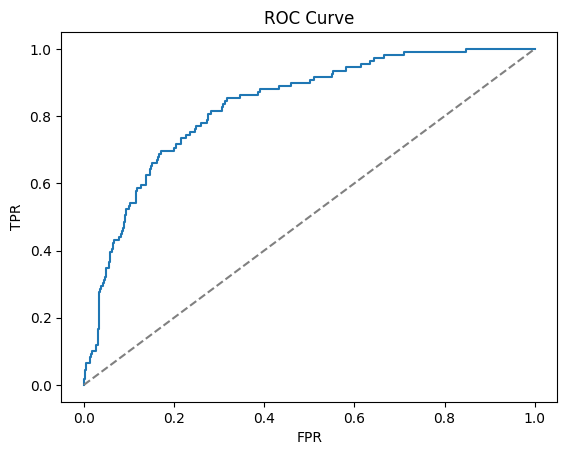

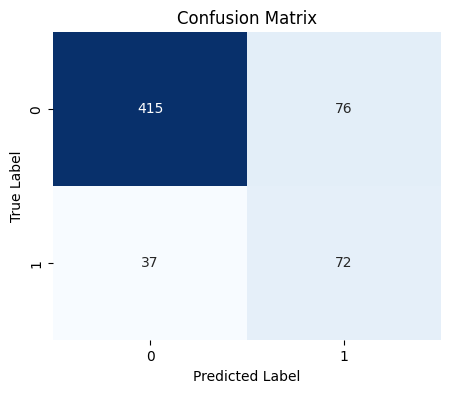

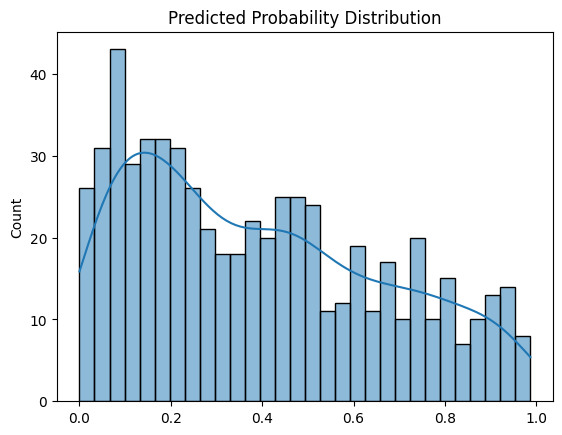

In [ ]:
y_pred = (probs_val >= final_thr).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, probs_val))
print("Log loss:", log_loss(y_test, probs_val))

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


# ROC Curve
fpr, tpr, _ = roc_curve(y_test, probs_val)
plt.plot(fpr, tpr, label="ROC-AUC")
plt.plot([0,1],[0,1],"--",color="gray")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC Curve"); plt.show()

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Probability distribution
sns.histplot(probs_val, bins=30, kde=True)
plt.title("Predicted Probability Distribution")
plt.show()

In [ ]:
def probs_for_etf(etf_ticker, df_all=data, model=clf):
    df_etf = df_all[df_all["etf_ticker"] == etf_ticker].copy()
    if df_etf.empty:
        print("No rows for:", etf_ticker)
        return None

    features = feature_cols_num + feature_cols_cat
    X_etf = df_etf[features]

    df_etf["p_in_top_k"] = model.predict_proba(X_etf)[:, 1]
    return df_etf.sort_values("p_in_top_k", ascending=False)

In [ ]:
# Example ETF Prediction (Ranked & Visualized)

# First ETF in sample universe
example_etf = universe.iloc[0]["localExchangeTicker"]
example_results = probs_for_etf(example_etf)
example_etf_name = universe[universe["localExchangeTicker"] == example_etf]["fundName"].values[0]

if example_results is None:
    print("No results for ETF:", example_etf)
else:
    # Sort by actual weight_pct (highest to lowest)
    example_results = example_results.sort_values("weight_pct", ascending=False)

    # Reset index to create rank index (1 = largest weight)
    example_results = example_results.reset_index(drop=True)
    example_results.index = example_results.index + 1   # start rank at 1
    example_results.index.name = "Rank"

    # Display top 15 cleanly
    print(f"\nTop Holdings — {example_etf_name} ({example_etf})\n")
    display(example_results[["Ticker", "sector", "p_in_top_k"]].head(5))



Top Holdings — iShares S&P 500 Value ETF (IVE)



,Ticker,sector,p_in_top_k
Rank,,,
1,AAPL,Information Technology,0.779354
2,MSFT,Information Technology,0.880205
3,AMZN,Consumer Discretionary,0.700699
4,AMD,Information Technology,0.582992
5,CSCO,Information Technology,0.858564


## How to Interpret Model Outputs

The model predicts the probability that a given security belongs to an ETF’s **top 25 holdings**.  
This probability represents the model’s confidence, based on both ETF-level style characteristics and
security-level performance features.

### 1. Predicted Probability (`model.predict_proba`)
For each security, the model outputs a value between 0 and 1:
- Values **near 1.0** indicate a strong match to the profile of high-weight positions in the ETF  
- Values **near 0.0** suggest the security resembles lower-weight or residual holdings

These probabilities can be used to **rank** all securities inside an ETF by estimated importance or exposure.

### 2. Hard Classification (`model.predict`)
The model also outputs a binary prediction:
- **1** = predicted to be a top-25 holding  
- **0** = predicted not to be  

The threshold for assigning 1 vs 0 can be adjusted depending on the goal:
- Higher thresholds -> higher precision (fewer false positives)  
- Lower thresholds -> higher recall (fewer missed true top holdings)

### 3. Confusion Matrix
The confusion matrix summarizes how well the classifier distinguishes true top-25 holdings from all others.  
Key components:
- **True Positives (TP)**  
- **False Positives (FP)**
- **True Negatives (TN)**
- **False Negatives (FN)**


### 4. ROC-AUC
ROC-AUC measures **ranking quality**:
- 0.50 = no better than random guessing  
- 1.00 = perfect ranking performance  

Thus 0.80 ≈ ̃the model meaningfully separates top holdings from lower-weight names  

ROC-AUC is important in context because ETF holdings are imbalanced (top-25 vs. hundreds of non-top holdings).

### 5. Log Loss
Log loss evaluates the **calibration** of predicted probabilities.  
Lower values indicate:
- more accurate probability estimates  
- better separation between high-likelihood and low-likelihood securities  
